## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import scipy as scipy
#import metpy as mtp
import math
from scipy import integrate
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

time_slice = slice('1980-01-01', '2021-12-31')

### Load instantaneous AHT calcs

In [4]:
aht_ds_6hrly = xr.open_dataset('../aht_time_series/era5_aht_time_series_full.nc').sel(time=time_slice)
aht_ds_6hrly

<xarray.Dataset>
Dimensions:                     (time: 61364, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1980-01-01 ... 2021-12-...
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

### Load precip and evap

In [36]:
precip_ds = xr.open_mfdataset('../era5_raw_data/precip/*')
evap_ds = xr.open_mfdataset('../era5_raw_data/evap/*')

In [37]:
precip_ds

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, time: 64284)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2022-12-31T18:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(1460, 361, 720), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-06 22:25:48 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [38]:
evap_ds

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, time: 64284)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2022-12-31T18:00:00
Data variables:
    e          (time, latitude, longitude) float32 dask.array<chunksize=(1460, 361, 720), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-06 22:22:22 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

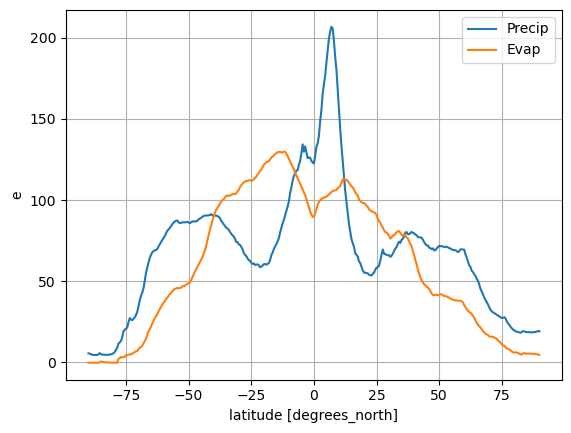

In [76]:
#(precip_ds.tp * (geometry[None,:,None] * g) * 111000 * L * 1000 / 3600).isel(time=slice(0, 1200)).mean(['time', 'longitude']).plot(label='Precip')
#(-evap_ds.e * (geometry[None,:,None] * g) * 111000 / L).isel(time=slice(0, 1200)).mean(['time', 'longitude']).plot(label='Evap')
(precip_ds.tp * L * 1000 / 3600).isel(time=slice(0, 1200)).mean(['time', 'longitude']).plot(label='Precip')
(-evap_ds.e * L * 1000 / 3600).isel(time=slice(0, 1200)).mean(['time', 'longitude']).plot(label='Evap')

plt.legend(loc=0)
plt.grid()
plt.show()

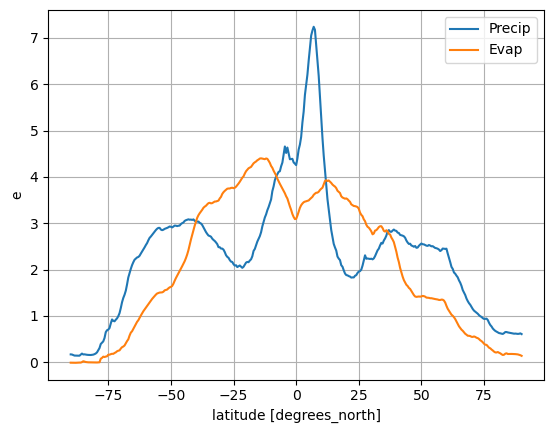

In [58]:
(4* 1000 * 6 * precip_ds.tp).isel(time=slice(0, 365 * 4)).mean(['time', 'longitude']).plot(label='Precip')
(4* 1000 * 6 * -evap_ds.e).isel(time=slice(0, 365 * 4)).mean(['time', 'longitude']).plot(label='Evap')

plt.legend(loc=0)
plt.grid()
plt.show()

In [30]:
#p_minus_e = (precip_ds.tp + evap_ds.e).mean('longitude')

#p_minus_e = p_minus_e.compute()

In [77]:
#p_minus_e.to_netcdf('zonal_mean_p_minus_e.nc')
p_minus_e = xr.open_dataset('zonal_mean_p_minus_e.nc')

In [78]:
p_minus_e = p_minus_e.__xarray_dataarray_variable__.sel(time=aht_ds_6hrly.time) * L * 1000 / 3600

p_minus_e

<xarray.DataArray '__xarray_dataarray_variable__' (time: 61364, latitude: 361)>
array([[-1.4920969 , -1.9459069 , -1.3911513 , ...,  0.5720066 ,
         0.19751067,  0.09159622],
       [-0.54165465, -0.6775143 ,  0.14018154, ...,  3.675925  ,
         1.9102865 ,  0.52876   ],
       [-1.2830749 , -1.2462273 , -0.92426753, ...,  0.80737555,
         0.69981295,  0.49080378],
       ...,
       [ 3.5959804 ,  4.225984  ,  3.9744701 , ..., 19.39376   ,
        19.581072  , 16.477982  ],
       [ 6.123607  ,  3.7346017 ,  4.814046  , ..., 27.803383  ,
        26.11046   , 25.467548  ],
       [ 0.7010385 ,  0.10809833, -0.134478  , ..., 21.816803  ,
        40.416595  , 44.90026   ]], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * time      (time) datetime64[ns] 1980-01-01 ... 2021-12-31T18:00:00

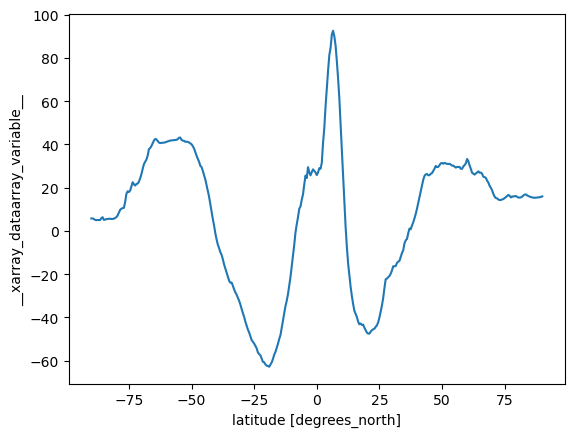

In [79]:
(p_minus_e).mean('time').plot()

plt.show()

In [80]:
moisture_conv = -aht_ds_6hrly.total_aht_moist.differentiate('latitude') / 111000 / (geometry * g)

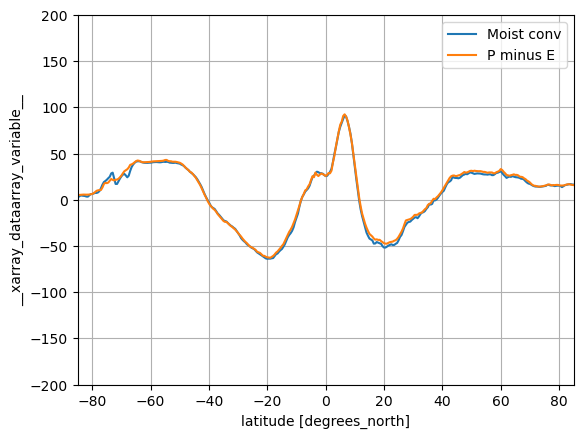

In [81]:
(moisture_conv.mean('time')).plot(label='Moist conv')
(p_minus_e).mean('time').plot(label='P minus E')
plt.xlim([-85, 85])
plt.ylim([-200, 200])
plt.grid()
plt.legend(loc=0)
plt.show()

In [136]:
mse_tendency_ds = xr.open_dataset('../MSE_zonal_tendency_no_ke.nc')
ps_ds = xr.open_dataset('../era5_raw_data/average_surf_pres.nc').sp
ps_zon_mean = ps_ds.mean('lon').values

In [139]:
moisture_conv_no_tend = moisture_conv - (mse_tendency_ds.q_tendency[:,::2]  / 6 / 3600 * ps_zon_mean / g)

In [140]:
moisture_conv_djf = moisture_conv.sel(time=moisture_conv.time.dt.month.isin([12, 1, 2]))
p_minus_e_djf = p_minus_e.sel(time=p_minus_e.time.dt.month.isin([12, 1, 2]))

moisture_conv_anom = moisture_conv.groupby('time.dayofyear') - moisture_conv.groupby('time.dayofyear').mean('time')
p_minus_e_anom = p_minus_e.groupby('time.dayofyear') - p_minus_e.groupby('time.dayofyear').mean('time')

corrs = xr.corr(moisture_conv, p_minus_e, dim='time')
corrs_anom = xr.corr(moisture_conv_anom, p_minus_e_anom, dim='time')
corrs_djf = xr.corr(moisture_conv_djf, p_minus_e_djf, dim='time')

In [141]:
slopes_annual = np.zeros(len(lats))
r_values_annual = np.zeros(len(lats))
slopes_anom = np.zeros(len(lats))
r_values_anom = np.zeros(len(lats))
slopes_djf = np.zeros(len(lats))
r_values_djf = np.zeros(len(lats))
slopes_no_tend = np.zeros(len(lats))
r_values_no_tend = np.zeros(len(lats))

for i in range(len(lats)):
    slopes_annual[i], intercept, r_values_annual[i], p_value, std_err = sc.linregress(moisture_conv[:,i],
                                                                                p_minus_e[:,i])
    slopes_anom[i], intercept, r_values_anom[i], p_value, std_err = sc.linregress(moisture_conv_anom[:,i],
                                                                                p_minus_e_anom[:,i])
    slopes_djf[i], intercept, r_values_djf[i], p_value, std_err = sc.linregress(moisture_conv_djf[:,i],
                                                                                p_minus_e_djf[:,i])
    slopes_no_tend[i], intercept, r_values_no_tend[i], p_value, std_err = sc.linregress(moisture_conv_no_tend[:,i],
                                                                                p_minus_e[:,i])

    

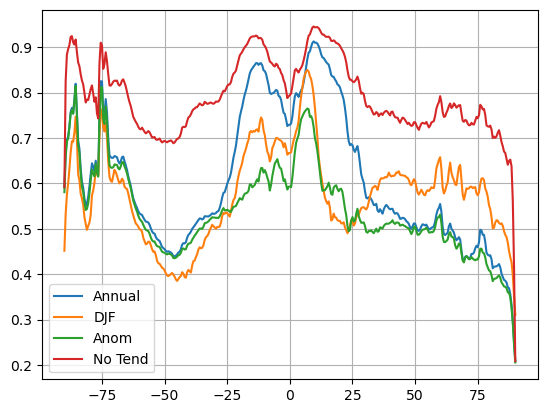

In [142]:
plt.plot(lats, r_values_annual, label='Annual')
plt.plot(lats, r_values_djf, label='DJF')
plt.plot(lats, r_values_anom, label='Anom')
plt.plot(lats, r_values_no_tend, label='No Tend')

plt.grid()
plt.legend(loc=0)
plt.show()

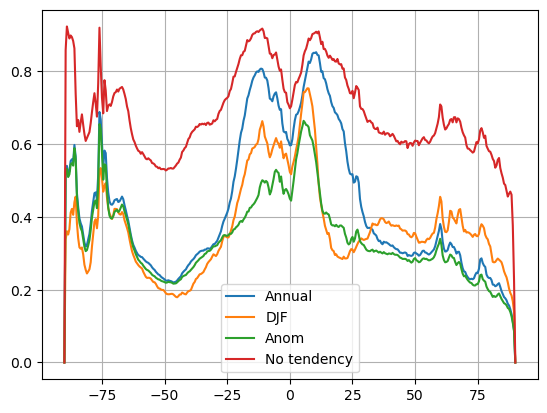

In [143]:
plt.plot(lats, slopes_annual, label='Annual')
plt.plot(lats, slopes_djf, label='DJF')
plt.plot(lats, slopes_anom, label='Anom')
plt.plot(lats, slopes_no_tend, label='No tendency')

plt.grid()
plt.legend(loc=0)
plt.show()

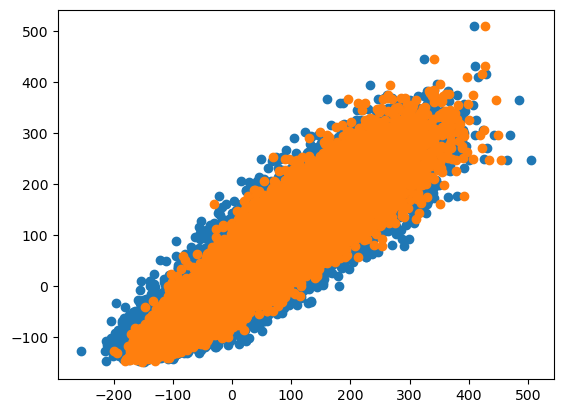

In [145]:
which_lat = 10

plt.scatter(moisture_conv.sel(latitude=which_lat), p_minus_e.sel(latitude=which_lat))
plt.scatter(moisture_conv_no_tend.sel(latitude=which_lat), p_minus_e.sel(latitude=which_lat))
plt.show()

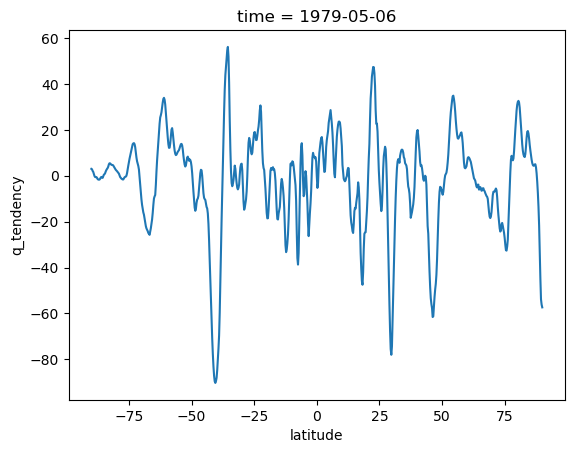

In [120]:

(mse_tendency_ds.q_tendency / 6 / 3600 * 100000 / g).isel(time=500).plot()

plt.show()


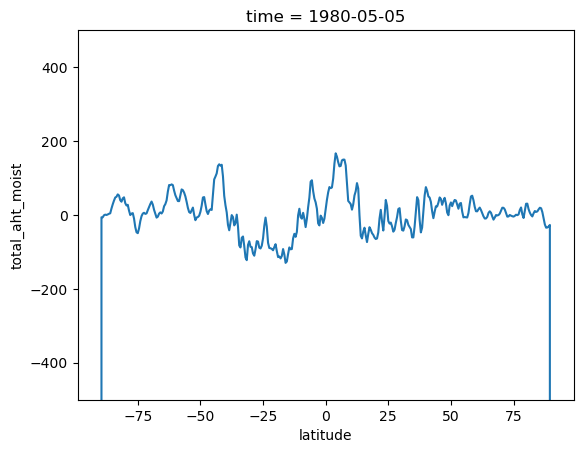

In [107]:
moisture_conv.isel(time=500).plot()
plt.ylim([-500, 500])
plt.show()